<a href="https://colab.research.google.com/github/VKSi/2021_01_NeuralNetworks_Intro/blob/main/HW_4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

# Решения

## Подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/NeuralNetwork/Lesson4/'

In [ ]:
import tensorflow as tf
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.4.0
TensorFlow 2.0 Hello World


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist

from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model, to_categorical

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier 

### Знакомимся с датасетом

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

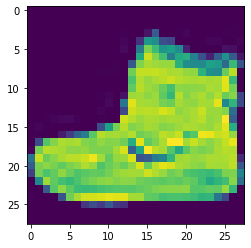

In [ ]:
plt.imshow(train_imagesi[0,:,:])
plt.show()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
y_test.shape

(10000,)

In [ ]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# конвертация чисел из uint8 в float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# нормализация данных [0, 1]
X_train /= 255 
X_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
X_train_reshaped = X_train.reshape(X_train.shape[0], 28,28,1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28,28,1)

## Базовая модель без свертки

In [ ]:
def baseline_model():
  inputs = Input(shape=(28, 28))
  x = Flatten()(inputs)
  x = Dense(128, activation='relu')(x)
  outputs = Dense(10, activation='softmax')(x)
  model = Model(inputs, outputs)
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')
  return model

In [ ]:
baseline_model().summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_107 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True, needs_proba=True)

In [ ]:
def print_simple_result(model_, X, y, metrics, number_of_folds=5, number_of_starts=1, number_of_epochs=15):
  results = list()
  for i in range(number_of_starts):
    kfold = KFold(n_splits=number_of_folds)
    estimator = KerasClassifier(build_fn=model_, epochs=number_of_epochs, batch_size=100, verbose=0)
    results += list(cross_val_score(estimator, X, y, cv=kfold))  # , scoring=accuracy_scorer

  print(f"{metrics}: среднее значение = {np.mean(results):.2f}, стандартное отклонение =  {np.std(results):.2f}")
  return results

In [ ]:
r = print_simple_result(baseline_model, X_train, y_train, metrics = 'accuracy', number_of_starts=5, number_of_epochs=15)

accuracy: среднее значение = 0.89, стандартное отклонение =  0.01


## Базовая модель со сверткой

Построим параметрическую процедуру (как и в 3-м домашнем задании)

In [ ]:
def parametric_model(kernel_sizes=[(5, 5)],
                     filters = [16, 64, 256, 512],
                     pool_size = (2, 2),
                     activation_func='relu',
                     optimizer_type='rmsprop',
                     loss_function='categorical_crossentropy',
                     metrics='accuracy'):
  def b_func():
    layers_number = len(kernel_sizes)
    inputs = Input(shape=(28,28,1))
    x = inputs
    for i in range(layers_number):
      x = Conv2D(filters=filters[i], kernel_size=kernel_sizes[i], strides=(1, 1), activation=activation_func, padding='valid')(x)  # , name='conv2d_'+str(i)
      x = MaxPooling2D(pool_size=pool_size)(x)  # name='pool_'+str(i)
    x = Flatten()(x)  # name='flatten_output'
    outputs = Dense(10, activation='softmax')(x)  # , name='dense_output'

    model = Model(inputs,outputs)
    model.compile(loss=loss_function, optimizer=optimizer_type, metrics=metrics)
    return model

  return b_func, b_func()

In [ ]:
pm_func, pm = parametric_model(kernel_sizes=[(5, 5)],
                               filters = [16, 64, 256, 512],
                               activation_func='relu',
                               optimizer_type='rmsprop',
                               loss_function='categorical_crossentropy',
                               metrics='accuracy')

In [ ]:
pm.summary()

Model: "model_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_194 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_140 (Flatten)        (None, 2304)              0         
_________________________________________________________________
dense_302 (Dense)            (None, 10)                23050     
Total params: 23,466
Trainable params: 23,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = print_simple_result(pm_func, X_train_reshaped, y_train, metrics = 'accuracy', number_of_starts=5, number_of_epochs=15)

accuracy: среднее значение = 0.90, стандартное отклонение =  0.01


Качество базовой сверточной модели несколько выше базовой полнослойной

Посмотрим насколько ухудшается качество на малом количестве эпох

In [ ]:
r = print_simple_result(pm_func, X_train_reshaped, y_train, metrics = 'accuracy', number_of_starts=5, number_of_epochs=5)

accuracy: среднее значение = 0.89, стандартное отклонение =  0.00


Можно строить зоопарк на меньшем количестве эпох, а потом посмотреть лучший результат на большем количестве эпох

## Зоопарк

Зависимость от количества ядер с одной группой слоев (количество эпох уменьшено до 3)

In [ ]:
for f in [1, 16, 64, 128, 256, 512]:
  pm_func, pm = parametric_model(kernel_sizes=[(5, 5)],
                               filters = [f],
                               activation_func='relu',
                               optimizer_type='rmsprop',
                               loss_function='categorical_crossentropy',
                               metrics='accuracy')
  print('filters = ', f)
  r = print_simple_result(pm_func, X_train_reshaped, y_train, metrics = 'accuracy', number_of_starts=5, number_of_epochs=3)

filters =  1
accuracy: среднее значение = 0.79, стандартное отклонение =  0.01
filters =  16
accuracy: среднее значение = 0.88, стандартное отклонение =  0.00
filters =  64
accuracy: среднее значение = 0.89, стандартное отклонение =  0.00
filters =  128
accuracy: среднее значение = 0.90, стандартное отклонение =  0.00
filters =  256
accuracy: среднее значение = 0.90, стандартное отклонение =  0.01
filters =  512
accuracy: среднее значение = 0.90, стандартное отклонение =  0.01


Похоже, как и в полносвязном слое, лучшее значение количества нейронов находится где-то в окрестности 200

Зависимость от количества слоев (количество фильтров увеличиваем)
Чтобы на изображении 28Х28 построить несколько слоев с пулингом, придется уменьшить размер ядра

In [ ]:
for n in range(1, 4):
  ks = (3, 3)
  kernel_sizes = [ks]*n
  pm_func, pm = parametric_model(kernel_sizes=kernel_sizes,
                               filters = [16, 64, 256],
                               activation_func='relu',
                               optimizer_type='rmsprop',
                               loss_function='categorical_crossentropy',
                               metrics='accuracy')
  print('n = ', n)
  r = print_simple_result(pm_func, X_train_reshaped, y_train, metrics = 'accuracy', number_of_starts=5, number_of_epochs=3)

n =  1
accuracy: среднее значение = 0.88, стандартное отклонение =  0.01
n =  2
accuracy: среднее значение = 0.87, стандартное отклонение =  0.01
n =  3
accuracy: среднее значение = 0.86, стандартное отклонение =  0.01


Увеличение количества слоев ухудшает результат ?

Посмотрим на результат с большим количеством эпох

In [ ]:
pm_func, pm = parametric_model(kernel_sizes=[(5, 5)],
                               filters = [256],
                               activation_func='relu',
                               optimizer_type='rmsprop',
                               loss_function='categorical_crossentropy',
                               metrics='accuracy')

In [ ]:
pm.summary()

Model: "model_534"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_537 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_531 (Conv2D)          (None, 24, 24, 256)       6656      
_________________________________________________________________
max_pooling2d_530 (MaxPoolin (None, 12, 12, 256)       0         
_________________________________________________________________
flatten_482 (Flatten)        (None, 36864)             0         
_________________________________________________________________
dense_644 (Dense)            (None, 10)                368650    
Total params: 375,306
Trainable params: 375,306
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = print_simple_result(pm_func, X_train_reshaped, y_train, metrics = 'accuracy', number_of_starts=5, number_of_epochs=15)

accuracy: среднее значение = 0.91, стандартное отклонение =  0.00


Качество модели получилось немного лучше чем на полносвязном слое